_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Name: Moritz Kniebel, Vanessa Tsingunidis

# Coding Lab 5

If needed, download the data files ```nda_ex_5_*.csv``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computationis. If you need help on that, there is lots of [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) are available online. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt
import math

mpl.rc("savefig", dpi=72)

from scipy import signal as signal

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [7]:
spikes = pd.read_csv('./data/nda_ex_5_spiketimes.csv') # neuron id, spike time
stims = pd.read_csv('./data/nda_ex_5_stimulus.csv')  # stimulus onset in ms, direction

stimDur = 2000.    # in ms
nTrials = 11       # number of trials per condition
nDirs = 16         # number of conditions
deltaDir = 22.5    # difference between conditions

stims['StimOffset'] = stims['StimOnset'] + stimDur

In [8]:
spikes

,Neuron,SpikeTimes
0,1,19.900000
1,1,29.866667
2,1,44.733333
3,1,55.033333
4,1,85.800000
...,...,...
223932,41,639602.133333
223933,41,639605.700000
223934,41,639638.266667
223935,41,639817.000000


We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [10]:
# you may add computations as specified above
spikes['Dir'] = np.nan
spikes['relTime'] = np.nan
spikes['Trial'] = np.nan
spikes['stimPeriod'] = np.nan

dirs = np.unique(stims['Dir'])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    
    trialcounter[dirs == row['Dir']] += 1
    
    i0 = spikes['SpikeTimes'] > row['StimOnset']
    i1 = spikes['SpikeTimes'] < row['StimOffset']
    
    select = i0.values & i1.values
    
    spikes.loc[select, 'Dir'] = row['Dir']
    spikes.loc[select, 'Trial'] = trialcounter[dirs == row['Dir']][0]
    spikes.loc[select, 'relTime'] = spikes.loc[select, 'SpikeTimes'] - row['StimOnset']
    spikes.loc[select, 'stimPeriod'] = True
    
spikes = spikes.dropna()

In [11]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


In [15]:
spikes


,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True
...,...,...,...,...,...,...
223463,41,599045.166667,202.5,1868.166667,11.0,True
223464,41,599063.233333,202.5,1886.233333,11.0,True
223465,41,599068.166667,202.5,1891.166667,11.0,True
223466,41,599080.200000,202.5,1903.200000,11.0,True


In [16]:
print('Spikes within Stimulation Period: '+str(sum(spikes['stimPeriod'])))

Spikes within Stimulation Period: 129738


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 2 pts*


In [30]:
def plotRaster(spikes, neuron):
    
    '''plot spike rasters for a single neuron sorted by condition
    
    Parameters
    ----------
    
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod
    
    neuron: int
        Neuron ID
        
        
    Note
    ----
    
    this function does not return anything, it just creates a plot!
    '''

    spikes_neuron = spikes[spikes['Neuron']==neuron]
    df_Dir = np.unique(spikes['Dir']) # find all possible directions
    plt.style.use('seaborn')

    plt.figure(figsize = (14,8))

    for dir in range(0, nDirs):
        current_dir = df_Dir[dir]
        current_spikes = spikes_neuron[spikes['Dir']==current_dir]
        ax = plt.subplot(nDirs,1,dir+1)
        ax.scatter(current_spikes.relTime,current_spikes.Trial,c='k',s=6,edgecolors='k') 
        ax.set_ylabel(str(current_dir))
        plt.xlabel('t [ms]')
        plt.ylim(0,nTrials+1)
        plt.xlim(0, np.max(spikes.iloc[:,3]))
        plt.yticks(visible=False)

    plt.tight_layout()

    plt.suptitle('Raster Plot: Neuron ' + str(neuron))
    plt.show()
    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


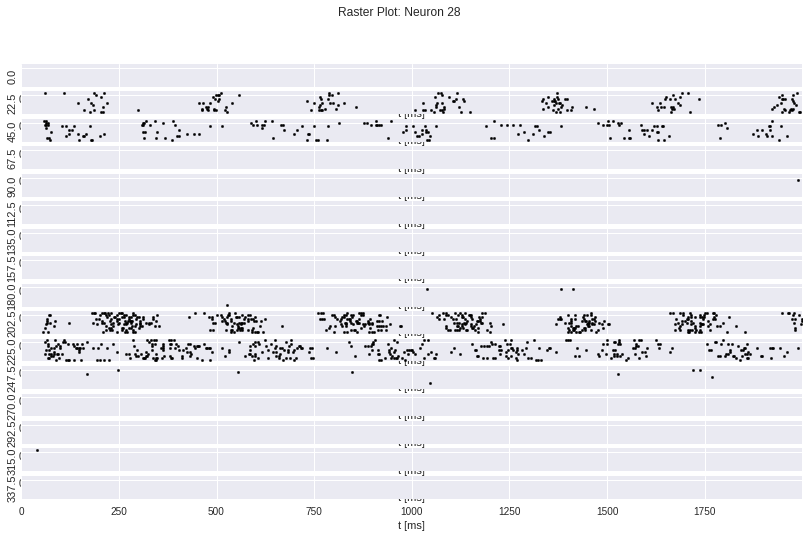

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


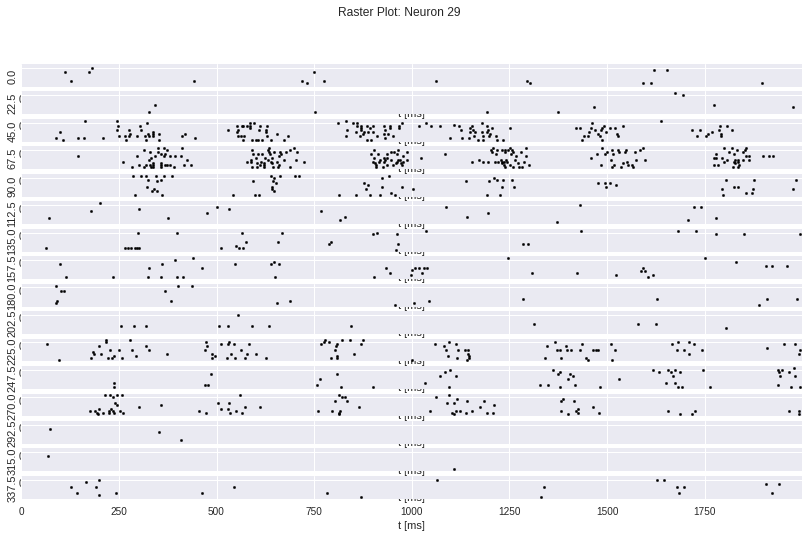

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


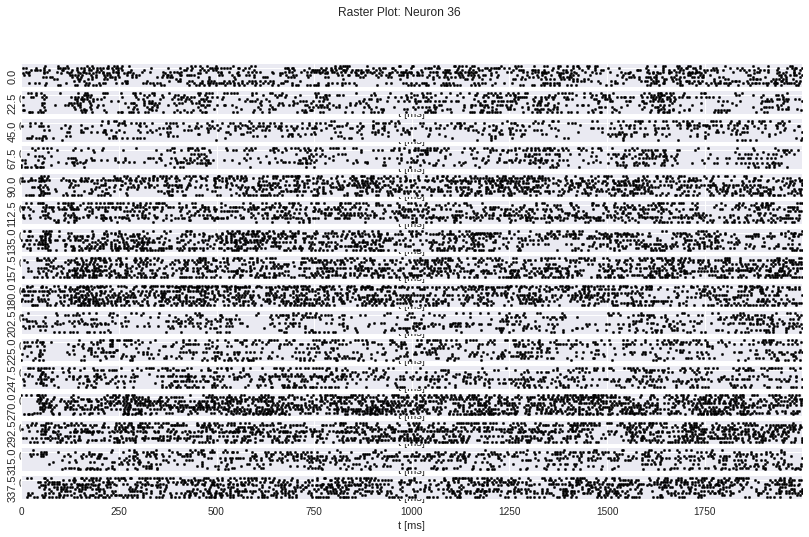

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


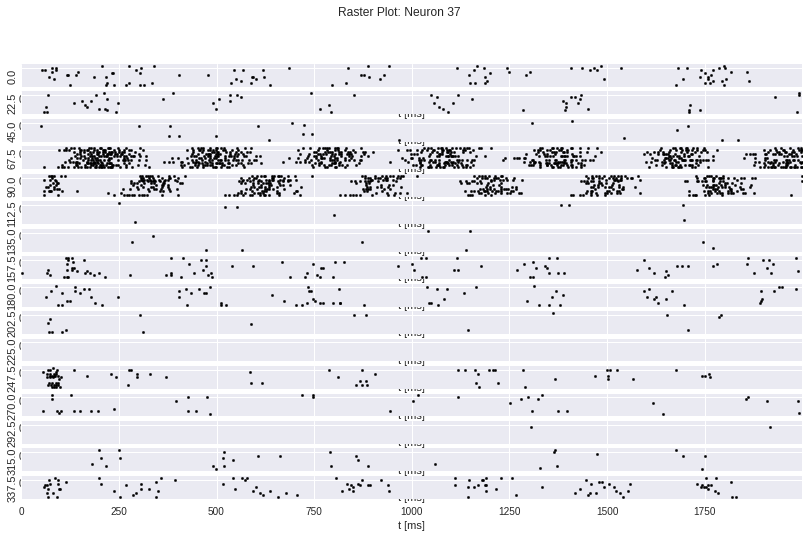

In [32]:
plotRaster(spikes, 28)
plotRaster(spikes, 29)
plotRaster(spikes, 36)
plotRaster(spikes, 37)

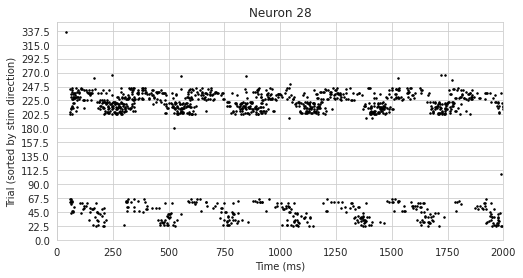

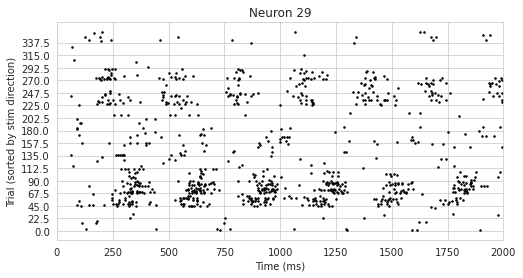

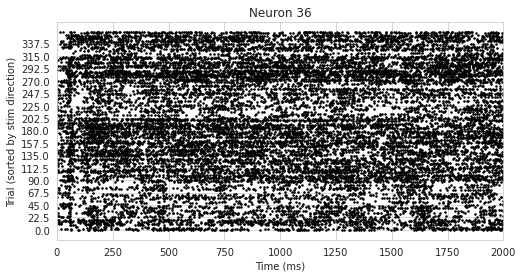

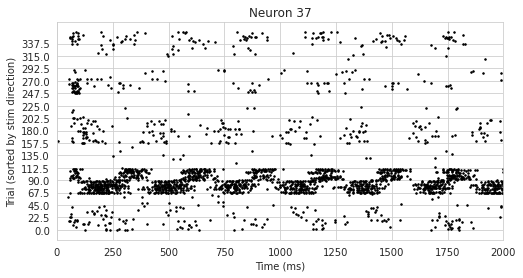

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

<span style='background: yellow'>Remark: a simple histogram is not enough here. </span>

Implement one of them in the function `plotPsth()`. If you use a dataframe you may need to change the interface of the function.


*Grading: 2 pts*


In [33]:
### Discretize time ###

# Choose bin size 
bin_size = 60

max_relTime = np.max(spikes.iloc[:,3])
binsize = np.ceil(max_relTime/bin_size)

In [50]:
def plotPSTH(spikes, neuron):
    '''Plot PSTH for a single neuron sorted by condition
    
    Parameters
    ----------
    
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod
    
    neuron: int
        Neuron ID
        
        
    Note
    ----
    
    this function does not return anything, it just creates a plot!
    '''
    spikes_neuron = spikes[spikes['Neuron']==neuron]
    df_Dir = np.unique(spikes_neuron['Dir'])[1:] # find conditions for the firing neuron

    plt.style.use('seaborn')
    plt.figure(figsize = (12,12))

    for d in range(0, df_Dir.shape[0]):
        current_dir = df_Dir[d]
        current_spikes = spikes_neuron[spikes['Dir']==current_dir]
        current_spiketimes = current_spikes.iloc[:,3].values 
        bin_idx = np.ceil(current_spiketimes/binsize)*binsize # spikes per bin
        ax = plt.subplot(nDirs,1,d+1)
        ax.set_ylabel(str(current_dir))
        plt.hist(bin_idx, bins = bin_size)

        plt.xlim(0, max_relTime)
        plt.ylim(12)
        plt.yticks([])
        plt.tight_layout()
        
    plt.xlabel('t[ms]')
    plt.suptitle('Spike rate estimate for neuron ' + str(neuron))
    plt.show()

    # ------------------------------------------------
    # Implement one of the spike rate estimates (1 pt)
    # ------------------------------------------------

    # ---------------------------------------------
    # Plot the obtained spike rate estimates (1 pt)
    # ---------------------------------------------
  

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


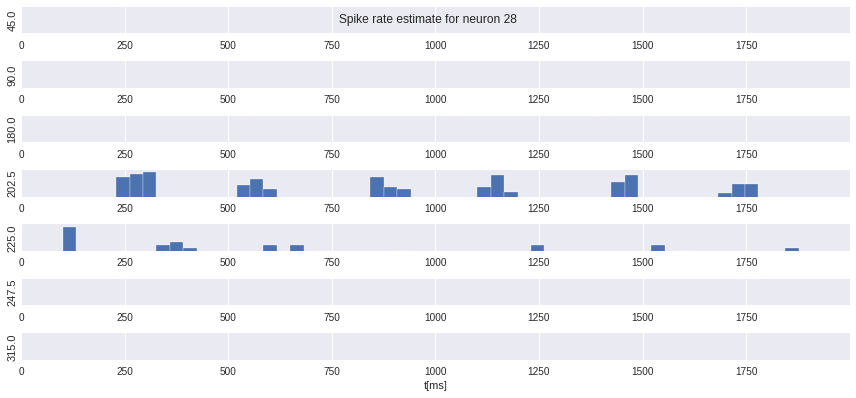

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


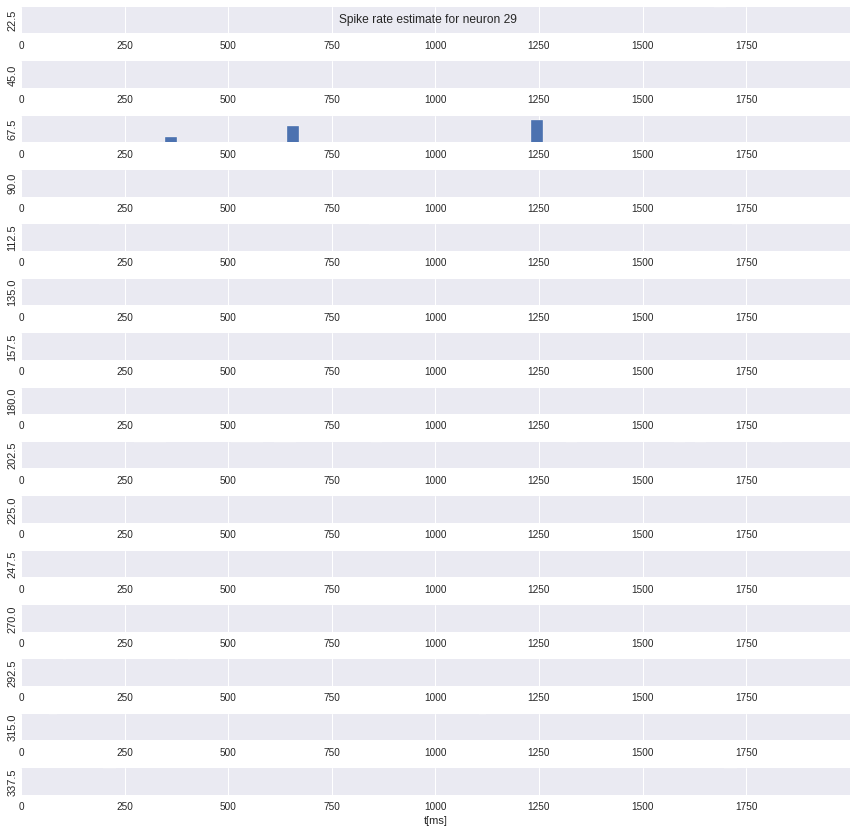

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


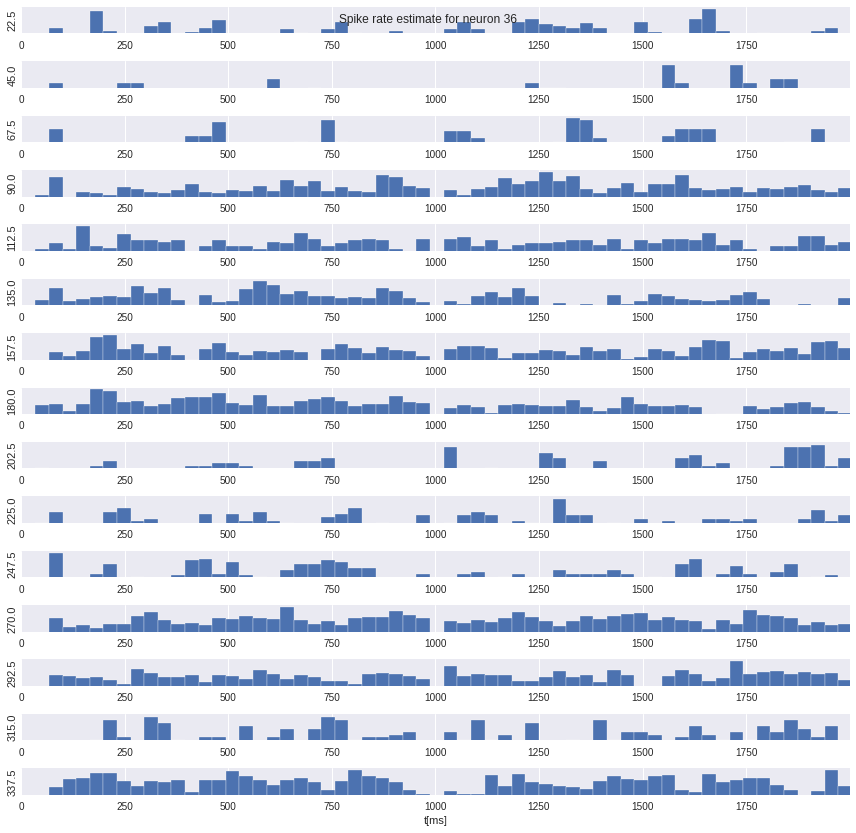

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


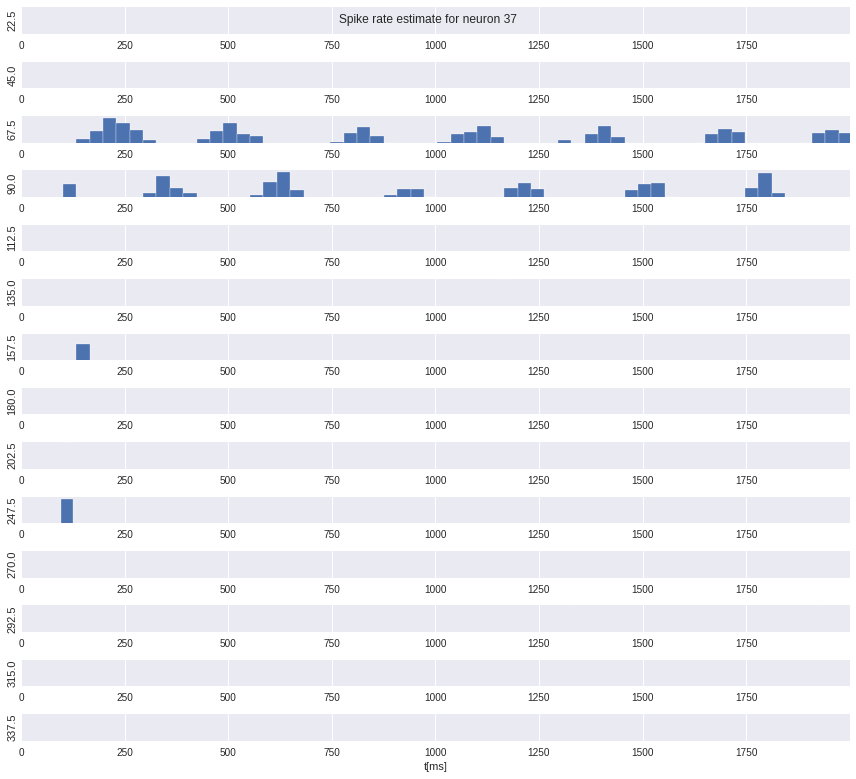

In [51]:
plotPSTH(spikes, 28)
plotPSTH(spikes, 29)
plotPSTH(spikes, 36)
plotPSTH(spikes, 37)

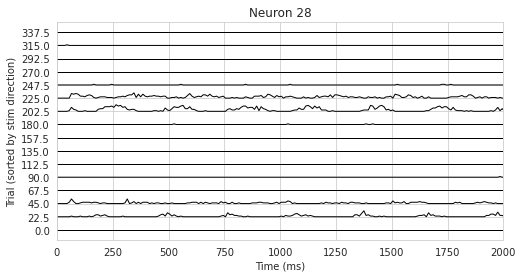

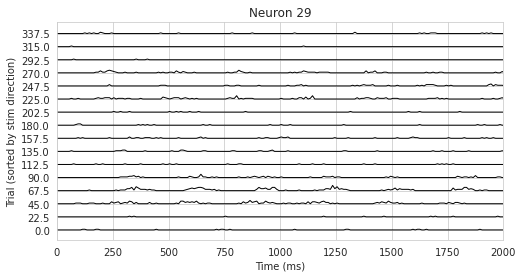

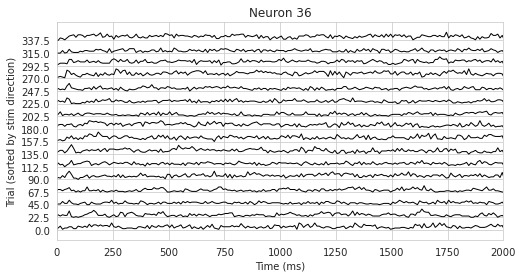

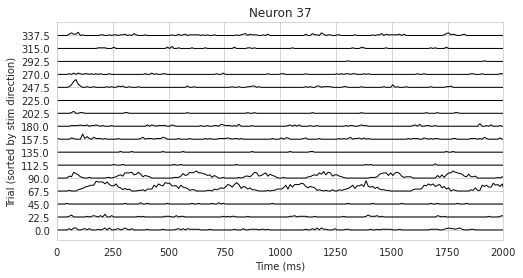

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


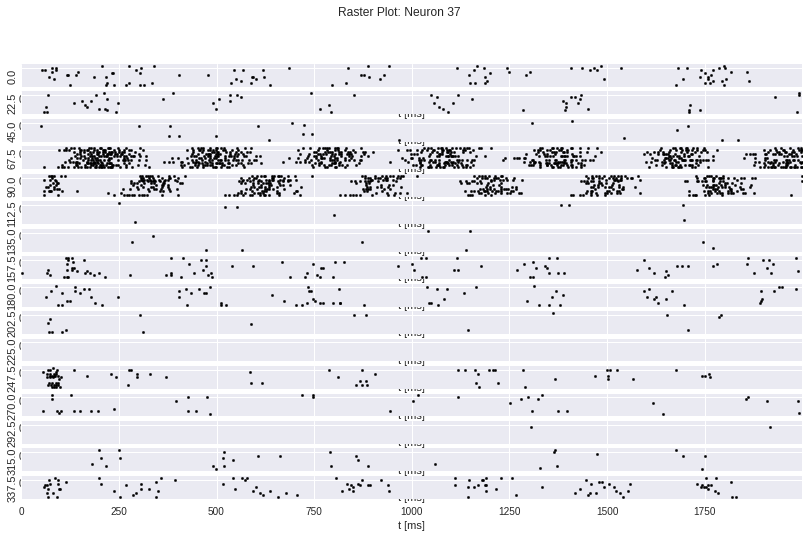

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


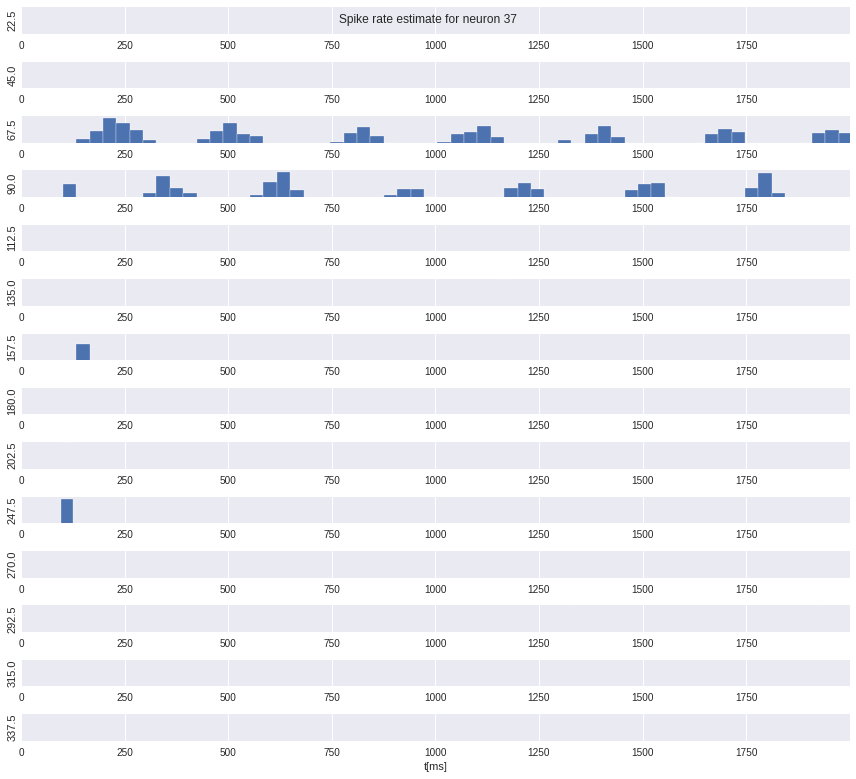

In [46]:
plotRaster(spikes, 37)
plotPSTH(spikes, 37)

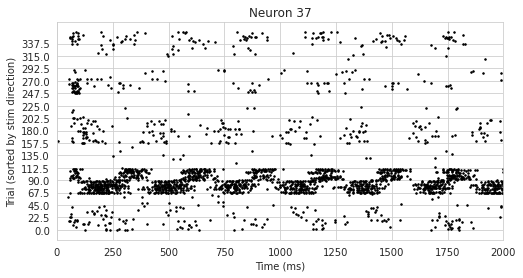

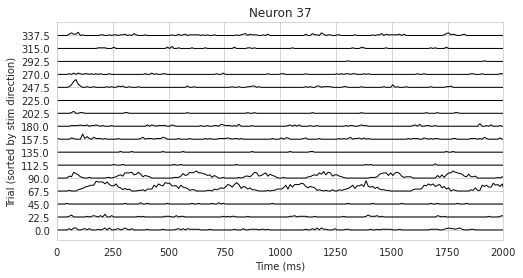

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactely. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test you code.

*Grading: 3 pts*

In [52]:
def vonMises(θ, α, κ, ν, ϕ):

    ''' Evaluate the parametric von Mises tuning curve with parameters p at locations theta. 
    
    Parameters
    ----------
    
    θ: np.array, shape=(N, )
        Locations. The input unit is degree.
        
    α, κ, ν, ϕ : float
        Function parameters
    
    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    '''

    theta = (θ*np.pi)/180  
    f = np.exp(α+ κ*(np.cos(2*(theta-ϕ)))-1) + ν*(np.cos(theta-ϕ)-1)
    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    
    return f
    

Plot the von Mises function while varying the parameters systematically.

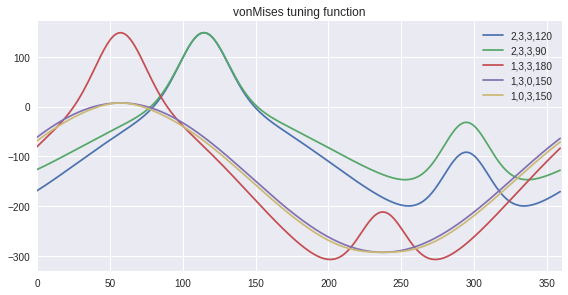

In [53]:
x = np.arange(0,360)

phi = [2,2,1,1,1]
alpha = [3,3,3,3,0]
kappa= [3,3,3,0,3]
nu = [120,90,180,150,150]
i_s = [0,1,2,3,4]



plt.figure(figsize=(8,4))
for i in i_s:
    f= vonMises(x, alpha[i], kappa[i], nu[i], phi[i])
    plt.plot(x,f,label= str(phi[i])+','+str(alpha[i])+','+str(kappa[i])+','+str(nu[i]))
    plt.legend()
plt.xlim(0,360)
plt.tight_layout()
plt.title('vonMises tuning function')
plt.show()

# --------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (0.5 pts)
# --------------------------------------------------------------------------------


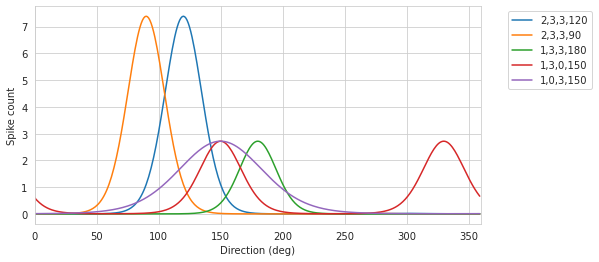

In [54]:
x = np.arange(0,360)

In [55]:
def tuningCurve(counts, dirs, show):

    '''Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.
    
    Parameters
    ----------
    
    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period
        
    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees
        
    show: bool
        Plot or not.
    
    
    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    '''

    counts = counts.mean(axis=0)

    p,_ = opt.curve_fit(vonMises,dirs,counts)
    
    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------


    f = vonMises(x,p[0],p[1],p[2],p[3])

    if show:
        plt.figure(figsize = (3,3))
        plt.bar(dirs,counts, width = 20,color = 'm')
        plt.plot(x,f)
        plt.title('vonMises tuning curve, fitted')
        plt.xlabel('orientation in degrees')
        plt.ylabel('intensity')
        plt.show()

    # -----------------------------------------------
    # plot the data and fitted tuning curve (0.5 pts)
    # -----------------------------------------------
        return
    else:
        return p

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [56]:
def get_data(spikes, neuron):
    spk_by_dir = spikes[spikes['Neuron']==neuron].groupby(['Dir','Trial'])['stimPeriod'].sum().astype(int).reset_index()

    dirs = spk_by_dir['Dir'].values
    counts = spk_by_dir['stimPeriod'].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes['Dir'])):
        m = nTrials-np.sum(dirs==Dir)
        if m>0:
            dirs = np.concatenate((dirs,np.ones(m)*Dir))
            counts = np.concatenate((counts,np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx] # sorted dirs
    counts_sorted = counts[idx]
            
    return dirs_sorted, counts_sorted

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


p = [ 2.96201356e+00 -4.02872184e-09 -3.56652826e-09  9.96717286e-01]


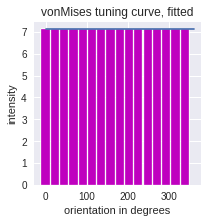

In [58]:
dirs, counts = get_data(spikes, 28)
tuningCurve(counts,dirs, True)

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


p = [ 2.96201356e+00 -4.02872184e-09 -3.56652826e-09  9.96717286e-01]


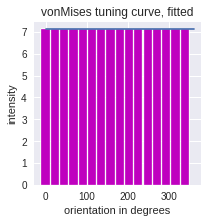

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


p = [ 2.57592813e+00 -5.50287887e-09 -1.09125147e-09  9.99551849e-01]


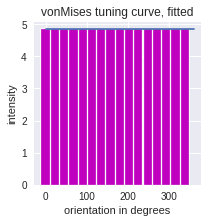

/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


p = [ 3.49245385e+00  6.54219997e-09 -1.87922079e-08  1.01316243e+00]


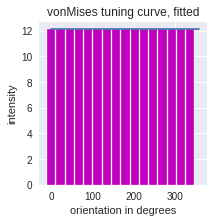

In [57]:
# ---------------------------------------------------------
# plot tuning curve and fit for different neurons (0.5 pts)
# ---------------------------------------------------------
neurons = [28,29,37]
for neuron in neurons:
    dirs, counts = get_data(spikes, neuron) # also test neurons 29 and 37
    tuningCurve(counts,dirs, True)

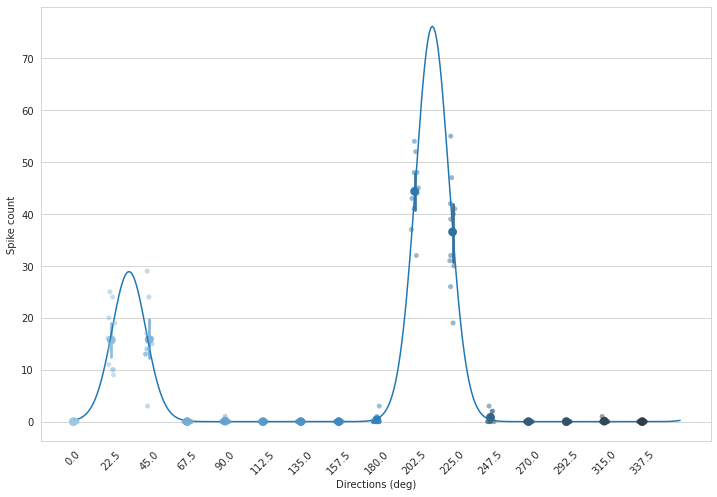

In [ ]:
dirs, counts = get_data(spikes, 29)
tuningCurve(counts,dirs, True)

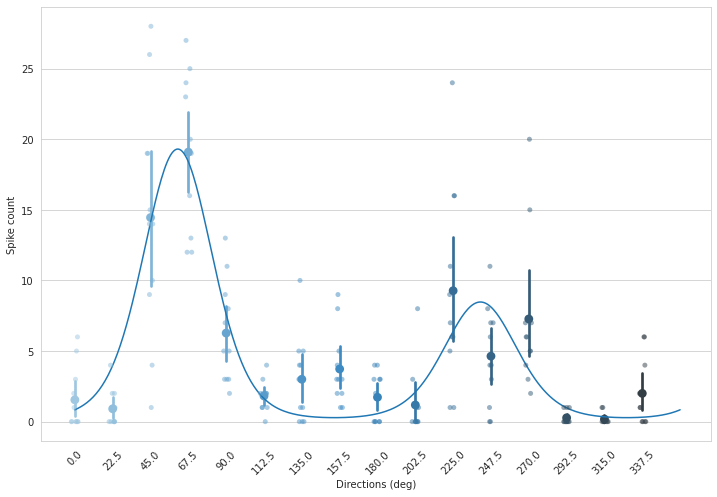

In [ ]:
dirs, counts = get_data(spikes, 36)
tuningCurve(counts,dirs, True)

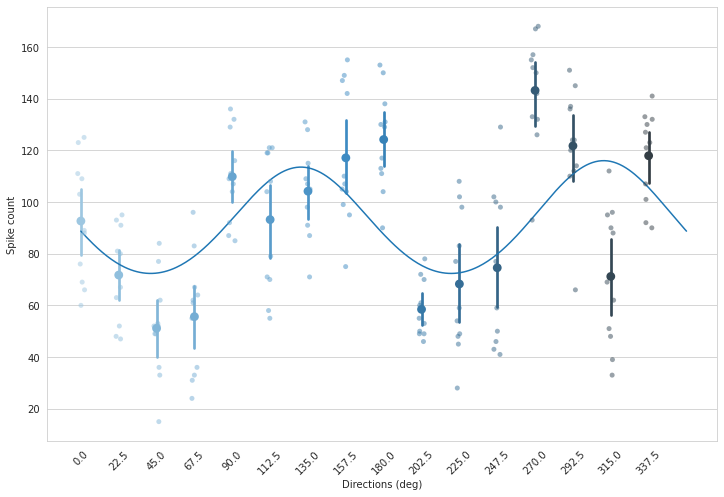

In [ ]:
dirs, counts = get_data(spikes, 37)
tuningCurve(counts,dirs, True)

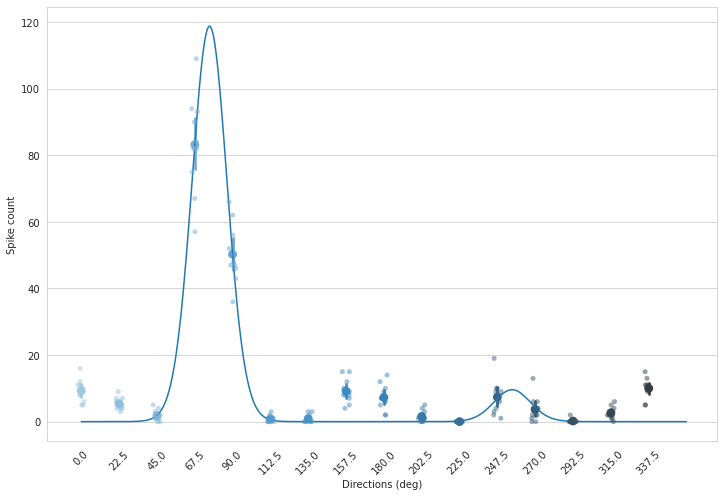

In [ ]:
dirs, counts = get_data(spikes, 32)
tuningCurve(counts,dirs, True)

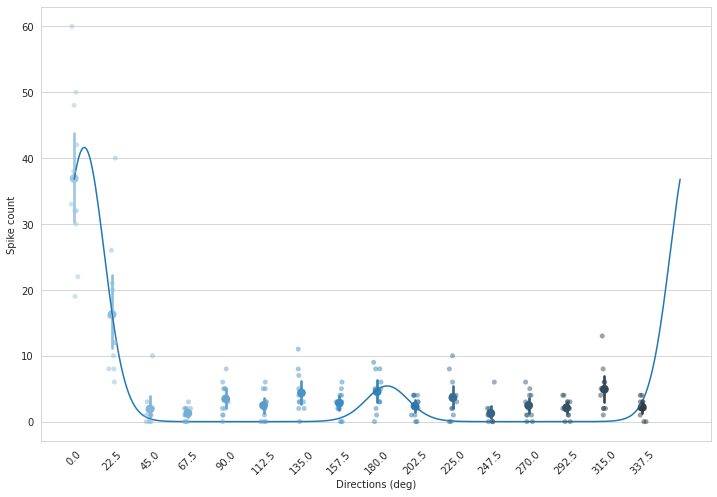

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [59]:
def testTuning(counts, dirs, psi=1, niters=1000, show=False):
    '''Plot the data if show is True, otherwise just return the fit.
    
    Parameters
    ----------
    
    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period
        
    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees
        
    psi: int
        fourier component to test (1 = direction, 2 = orientation)
        
    niters: int
        Number of iterations / permutation
        
    show: bool
        Plot or not.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component
        
    qdistr: np.array
        sampling distribution of |q| under the null hypothesis    

    '''
    
    # average spike counts
    m = np.mean(counts, axis=0)
    # complex exponential for all k (directions)
    v = np.exp(psi*1j*dirs)
    # projection
    q = m@v
    power = np.abs(q)
      
    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------
    qdistr = np.zeros(niters)
    random_trials = np.zeros(counts.shape)

    for i in range(niters):
        for t in range(nTrials):
            random_trials[t,:] = counts[t,np.random.permutation(range(nDirs))]
        m = np.mean(random_trials,axis=0)
        q_i = m@v
        qdistr[i] = abs(q_i)
    
    # compute p value
    more_extreme = qdistr >= power
    p = np.sum(more_extreme)/niters
    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    
    if show:
        figure = plt.figure(figsize=(8,10))
        ax = sns.distplot(qdistr)
        y = ax.get_ylim()
        # plot real q
        plt.plot([power,power],[0,y[1]],'b',linewidth=2,label='real |q| = '+str(round(power,3)))
        plt.xlabel('|q|')
        plt.title('Distribution of |q| with permutation test')
        plt.legend()
        plt.show()
    # -------------------------------
    # plot the test results (0.5 pts)
    # -------------------------------
    
    else:
        return p, q, qdistr 

Show null distribution for the example cell:

In [60]:
dirs, counts = get_data(spikes, 28)

testTuning(dirs, counts, show=True, psi=2)
# ------------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (0.5 pts)
# ------------------------------------------------------------
        

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

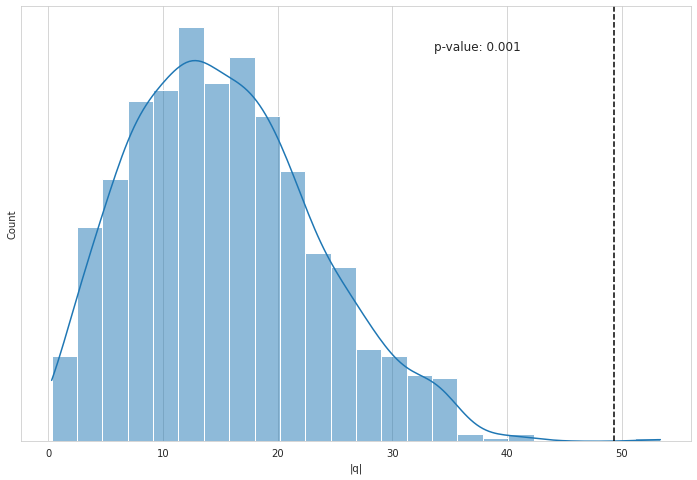

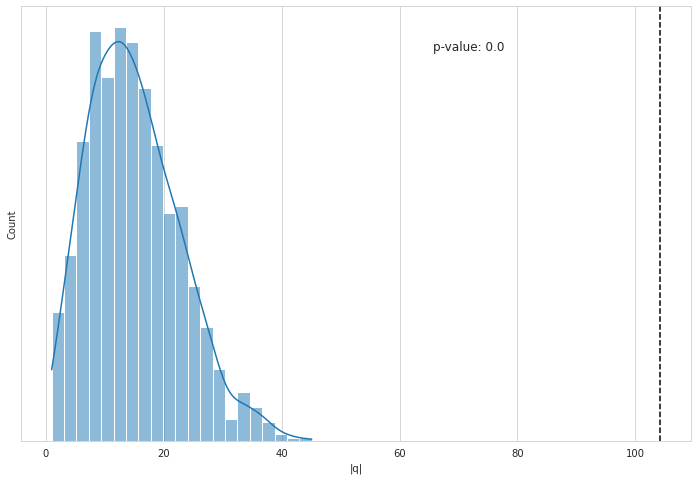

In [ ]:
dirs, counts = get_data(spikes, 29)

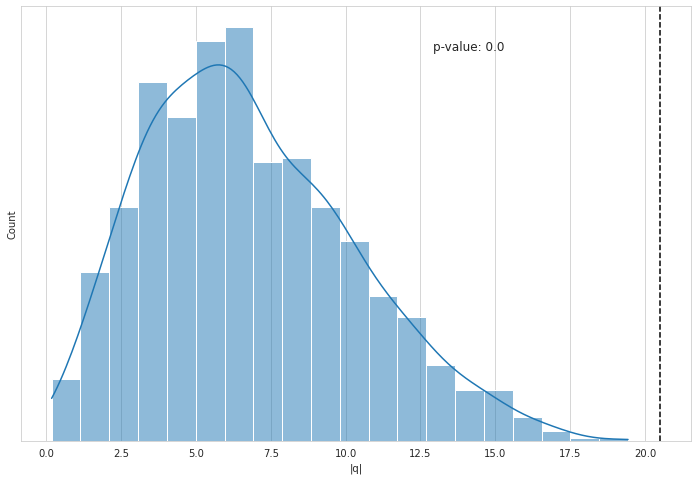

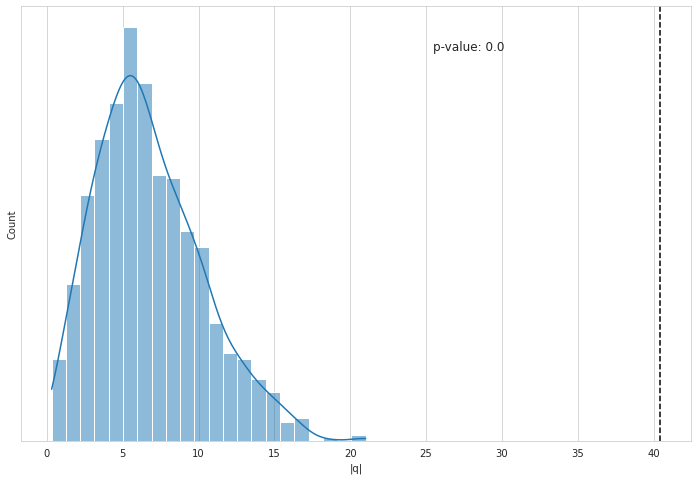

Test all cells for orientation and direction tuning

In [ ]:
# -------------------------------------------------------
# Test cells for orientation / direction tuning (0.5 pts)
# -------------------------------------------------------

Number of direction tuned neurons:

In [ ]:
np.sum(p_dir<0.01)

Number of orientation tuned neurons:

In [ ]:
np.sum(p_ori<0.01)